## Simulating the spin model:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import interact, IntSlider
import scipy.linalg as la

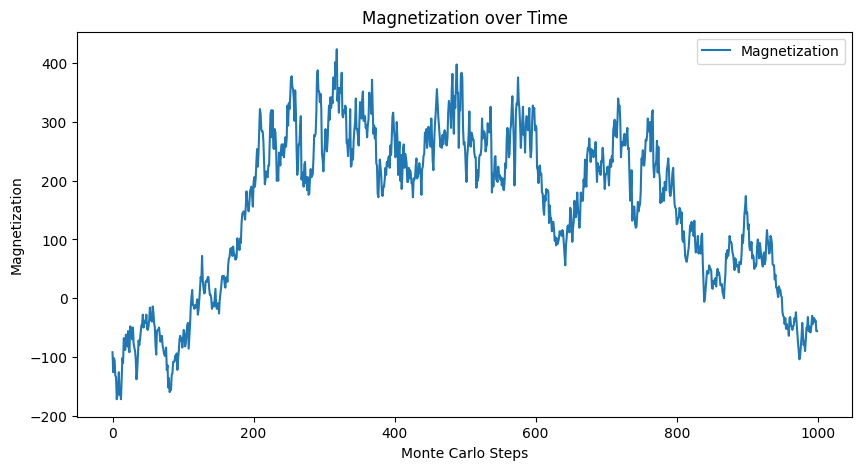

interactive(children=(IntSlider(value=0, description='t', max=999), Output()), _dom_classes=('widget-interact'…

In [2]:
def local_field(spins, size, J, alpha, i, j):
    """Compute the local field at site (i, j)"""
    neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
    total_neighbors = sum(spins[x % size, y % size] for x, y in neighbors)
    magnetization = np.sum(spins) / (size * size)
    return J * total_neighbors - alpha * spins[i, j] * abs(magnetization)

class SpinMarketModel:
    def __init__(self, size=32, J=1, alpha=4, T=1.5, steps=10000, local_field_func=None):
        self.size = size
        self.J = J  # Ferromagnetic coupling
        self.alpha = alpha  # Global anti-ferromagnetic coupling
        self.T = T  # Temperature
        self.steps = steps  # Number of Monte Carlo sweeps
        self.spins = np.random.choice([-1, 1], (size, size))  # Initialize spins randomly
        self.local_field_func = local_field_func
    
    def metropolis_step(self):
        """Perform a single Metropolis update"""
        for _ in range(self.size * self.size):
            i, j = np.random.randint(0, self.size, 2)
            # here we neglect the boltzmann constant as it has no physical meaning in our application
            p = 1/(1 + np.exp(-2 * self.local_field_func(self.spins, self.size, self.J, self.alpha, i, j) / self.T))
            if np.random.rand() < p:
                self.spins[i, j] = +1
            else:
                self.spins[i, j] = -1
    
    def run_simulation(self):
        """Run the Monte Carlo simulation"""
        spin_series = []
        for step in range(self.steps):
            self.metropolis_step()
            spin_series.append(np.copy(self.spins))
        return spin_series

    def plot_magnetization(self, spin_series):
        """Plot the time series of magnetization"""
        magnetization_series = [np.sum(spin) for spin in spin_series]
        plt.figure(figsize=(10, 5))
        plt.plot(magnetization_series, label="Magnetization")
        plt.xlabel("Monte Carlo Steps")
        plt.ylabel("Magnetization")
        plt.title("Magnetization over Time")
        plt.legend()
        plt.show()
    
    def plot_lattice(self, spin_series, t=None, interactive=False):
        """
        Plots the 2D lattice at time t.
        """
        if t is None:
            t = len(spin_series) - 1
        if interactive:
            interact(lambda t: self.plot_lattice(spin_series, t), t=IntSlider(min=0, max=len(spin_series)-1, step=1, value=0))
        else:
            plt.figure(figsize=(8, 8))
            plt.imshow(spin_series[t], cmap='binary', interpolation='none')
            plt.title(f'Lattice at time t={t}')
            plt.colorbar(label='Value')
            plt.show()


# Running the simulation
model = SpinMarketModel(size=32, J=1, alpha=4, T=1.5, steps=1000, local_field_func=local_field)
spin_series = model.run_simulation()
model.plot_magnetization(spin_series)
model.plot_lattice(spin_series=spin_series, interactive=True)

Logic for code below:
- the matrix _offdi_ is the adjacency matrix of a path graph
- the kronecker sum of offdi with itself is the grid graph (see https://en.wikipedia.org/wiki/Kronecker_product#Abstract_properties)
- code partly from https://stackoverflow.com/questions/16329403/how-can-you-make-an-adjacency-matrix-which-would-emulate-a-2d-grid
- other resource on creating lattice graphs: https://mathworld.wolfram.com/GraphCartesianProduct.html

In [2]:
def lattice_2d_connection_matrix(dim):
    offdi = la.circulant([0,1] + [0]*(dim-3) + [1])
    I = np.eye(dim)
    return np.kron(offdi,I) + np.kron(I,offdi) #kronecker sum of offdi and offdi

In [9]:
def lattice_connection_matrix(side, dim):
    path = la.circulant([0,1] + [0]*(side-3) + [1])
    I = np.eye(side)
    if dim == 1:
        return path
    elif dim == 2:
        return np.kron(path,I) + np.kron(I,path)
    else:
        return lattice_connection_matrix(side, dim-1) + np.kron(I, path)

In [3]:
def local_field(model, i):
    """Compute the local field at site i"""
    total_neighbors = np.sum(model.connection_matrix[i] * model.spins)
    magnetization = np.sum(model.spins) / len(model.spins)
    return model.J * total_neighbors - model.alpha * model.spins[i] * magnetization

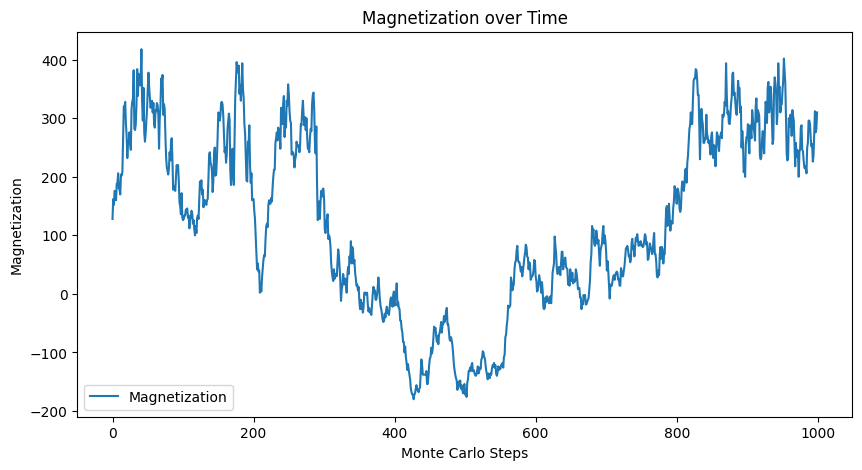

interactive(children=(IntSlider(value=0, description='t', max=999), Output()), _dom_classes=('widget-interact'…

In [ ]:
class SpinMarketModel:
    def __init__(self, size=1024, J=1, alpha=4, T=1.5, steps=10000, local_field_func=None, connection_matrix=None):
        self.size = size
        self.J = J  # Ferromagnetic coupling
        self.alpha = alpha  # Global anti-ferromagnetic coupling
        self.T = T  # Temperature
        self.steps = steps  # Number of Monte Carlo sweeps
        self.spins = np.random.choice([-1, 1], size)  # Initialize spins randomly
        self.local_field_func = local_field_func
        self.connection_matrix = connection_matrix if connection_matrix is not None else np.ones((size, size)) - np.eye(size)
    
    def metropolis_step(self):
        """Perform a single Metropolis update"""
        for _ in range(self.size):
            i = np.random.randint(0, self.size)
            # here we neglect the boltzmann constant as it has no physical meaning in our application
            p = 1/(1 + np.exp(-2 * self.local_field_func(self, i) / self.T))
            if np.random.rand() < p:
                self.spins[i] = +1
            else:
                self.spins[i] = -1
    
    def run_simulation(self, verbose=False):
        """Run the Monte Carlo simulation"""
        spin_series = []
        for step in range(self.steps):
            if verbose and step % int(self.steps/10) == 0:
                print(f"Step {step}/{self.steps}")
            self.metropolis_step()
            spin_series.append(np.copy(self.spins))
        return spin_series

    def plot_magnetization(self, spin_series):
        """Plot the time series of magnetization"""
        magnetization_series = [np.sum(spin) for spin in spin_series]
        plt.figure(figsize=(10, 5))
        plt.plot(magnetization_series, label="Magnetization")
        plt.xlabel("Monte Carlo Steps")
        plt.ylabel("Magnetization")
        plt.title("Magnetization over Time")
        plt.legend()
        plt.show()
    
    
# need to update this class to use the general connection matrix function !!!
class SpinMarketModel2dLattice(SpinMarketModel):
    def __init__(self, side=32, J=1, alpha=4, T=1.5, steps=10000, local_field_func=None):
        self.size = side**2
        self.J = J  # Ferromagnetic coupling
        self.alpha = alpha  # Global anti-ferromagnetic coupling
        self.T = T  # Temperature
        self.steps = steps  # Number of Monte Carlo sweeps
        self.spins = np.random.choice([-1, 1], (self.size))  # Initialize spins randomly
        self.local_field_func = local_field_func
        self.connection_matrix = lattice_2d_connection_matrix(side)

    def plot_lattice(self, spin_series, t=None, interactive=False):
        """
        Plots the 2D lattice at time t.
        """
        if t is None:
            t = len(spin_series) - 1
        if interactive:
            interact(lambda t: self.plot_lattice(spin_series, t), t=IntSlider(min=0, max=len(spin_series)-1, step=1, value=0))
        else:
            side = int(np.sqrt(self.size))
            plt.figure(figsize=(8, 8))
            plt.imshow(spin_series[t].reshape(side, side), cmap='binary', interpolation='none')
            plt.title(f'Lattice at time t={t}')
            plt.colorbar(label='Value')
            plt.show()



# Running the simulation
model = SpinMarketModel2dLattice(side=32, J=1, alpha=4, T=1.5, steps=1000, local_field_func=local_field)
spin_series = model.run_simulation()
model.plot_magnetization(spin_series)
model.plot_lattice(spin_series=spin_series, interactive=True)